# Dimension Dependence for Axial Modes Density

In this experiment we consider the target distribution $\nu$ given by (unnormalized) density

$$
\varrho_{\nu}(x)
= \Vert x \Vert_{\infty}^4 \exp(-\Vert x \Vert_1) ,
\qquad x \in \mathbb{R}^d ,
$$

in several different dimensions $d=10,20,...,100$. As a result of the counteracting forces of $\infty$-norm and $1$-norm, $\nu$ possesses $2d$ well-pronounced modes, two along each coordinate axis (see illustration below). 

Naturally, a good sampler for $\nu$ will need to frequently jump between the different modes. This motivates measuring the samplers' performances on this target by how well they accomplish this mode-jumping. To this end, we define a function

$$
\text{axis}(x) := \arg \max_{1 \leq j \leq d} \vert x_j \vert ,
\qquad x = (x_1,...,x_d)^T \in \mathbb{R}^d ,
$$

that intuitively assigns each point $x$ to a pair of modes, identified by the coordinate axis they lie on, by finding the axis $j$ along which $x$ is the farthest from the origin. With this function at hand, we can introduce the notion that a sampler *mode-jumped* in step $i$ if and only if

$$
\text{axis}(x^{(i)}) \neq \text{axis}(x^{(i-1)}) ,
$$

where $(x^{(k)})_{k=1,...,n} \subset \mathbb{R}^d$ are the samples under consideration. This in turn opens the door to a number of interesting performance metrics, such as *total number of jumps* (within a given number of iterations), *mean dwelling time* (average number of iterations spent at a mode pair before jumping to the next). The latter is more intuitive because it does not depend (at least not in the same way) on the total number of iterations. One may also consider the *maximum dwelling time* (largest number of iterations spent at a mode pair without leaving), as this can more reliably detect if a chain occasionally gets stuck at a mode pair for excessively large numbers of iterations. Below we computed mean dwelling time and maximum dwelling time and plotted their progression across the different choices of the sample space dimension $d$. Additionally we plot the progressions of the $\text{axis}$ values across each sampler's iterations in the highest dimension $d$.

Note that $\nu$ serves as an example of a highly multi-modal target, and GPSS showing reasonably good performance for it shows that the method can, in principle, handle multi-modality fairly well. An important caveat to this is that, in performing these mode jumps for $\nu$, GPSS relies heavily on all its modes having the exact same distance from the coordinate origin. For multi-modal targets whose modes are not distributed in such a regular fashion, GPSS cannot be expected to perform similarly well.

In [1]:
import slice_sampling as ss
import mcmc_utils as uti
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import time as ti
import matplotlib.pyplot as plt
from fastprogress import progress_bar

### Construct Target, Prepare Automatic Sampler Parameter Choices

In [2]:
# set parameters
ds = range(10,101,10) # dimensions to be used
nd = len(ds)
itnum = int(1e5) # number of iterations for each dimension and sampler
dpi = 250
path_prefix = "../plots/axial_modes_"

In [3]:
tde_cnt = 0 # target density evaluation count

In [4]:
def log_density(x):
    global tde_cnt
    tde_cnt += 1
    return 4*np.log(alg.norm(x, ord=np.inf)) - alg.norm(x, ord=1)

In [5]:
# this may look weird but believe me, this is the most plausible value sample I managed to find
x_0_gen = lambda d: np.concatenate([np.array([5.0]), np.ones(d-1)])

In [6]:
w_gen = lambda d: 10.0

### Create Illustration

In [7]:
density = lambda x: np.exp(log_density(x))
ext = 10
G1, G2, vals = pfs.contour_precalc(300, -ext, ext, -ext, ext, density)

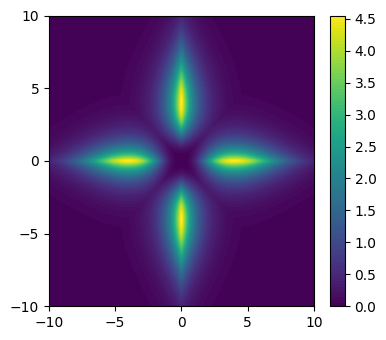

In [8]:
plt.figure(figsize=(4,3.5))
plt.yticks(range(-10,11,5))
plt.contourf(G1, G2, vals, levels=100)
plt.colorbar()
plt.tight_layout()
plt.savefig(path_prefix + "target.png", dpi=dpi)
plt.show()
tde_cnt = 0

The above plot shows the target distribution $\nu$ in dimension $d=2$. It can be seen that $\nu$ does indeed have two modes on each coordinate axis, and that these modes are fairly well-separated by regions of low probability.

### Run Samplers in Different Dimensions

In [9]:
samplers   = [ss.gibbsian_polar_ss, ss.hit_and_run_uniform_ss, ss.naive_elliptical_ss,  ss.elliptical_ss, ]
names      = ["GPSS", "HRUSS", "Untuned ESS", "Tuned ESS"]
long_names = ["Gibbsian Polar Slice Sampling", "Hit-and-Run Uniform Slice Sampling", "Untuned Elliptical Slice Sampling", "Tuned Elliptical Slice Sampling"]
nsam = len(samplers)

In [10]:
# Compute sample radii asap to avoid having to store all samples for multiple samplers and dimensions
tde_cnts = np.zeros((nsam,nd))
radii = [nd * [None] for _ in range(nsam)]
moxes = [nd * [None] for _ in range(nsam)]

for i_d, d in enumerate(progress_bar(ds)):
    x_0 = x_0_gen(d)
    w = w_gen(d)
    for i_s, sampler in enumerate(samplers):
        if i_s in [0,1]:
            samples = sampler(log_density, x_0, w, itnum, False)
        elif i_s == 2:
            samples = sampler(log_density, x_0, itnum, False)
        elif i_s == 3:
            var = float( ((5+d/10)/np.sqrt(d))**2 )
            log_likelihood = lambda x: -ss.log_prior_identity(var, x) + log_density(x)
            samples = sampler(var, log_likelihood, x_0, itnum, False)
        tde_cnts[i_s][i_d] = tde_cnt
        tde_cnt = 0
        radii[i_s][i_d] = alg.norm(samples, axis=1)
        moxes[i_s][i_d] = np.argmax(np.abs(samples), axis=1)

### Compute Performance Metrics

In [11]:
# target density evaluation counts
tdes_per_it = tde_cnts / itnum

In [12]:
# mean dwelling times
jumps = np.zeros((nsam, nd))
for i_s in range(nsam):
    for i_d in range(nd):
        jumps[i_s,i_d] = np.sum(moxes[i_s][i_d][1:] != moxes[i_s][i_d][:-1])
mean_dts = (itnum+1)/(jumps+1)

In [13]:
# maximum dwelling times
max_dts = np.zeros((nsam,nd))
for i_s in range(nsam):
    for i_d in range(nd):
        jump_inds = np.arange(itnum)[moxes[i_s][i_d][1:] != moxes[i_s][i_d][:-1]]
        dts = jump_inds[1:] - jump_inds[:-1]
        max_dts[i_s,i_d] = np.max(dts)

### Plotting

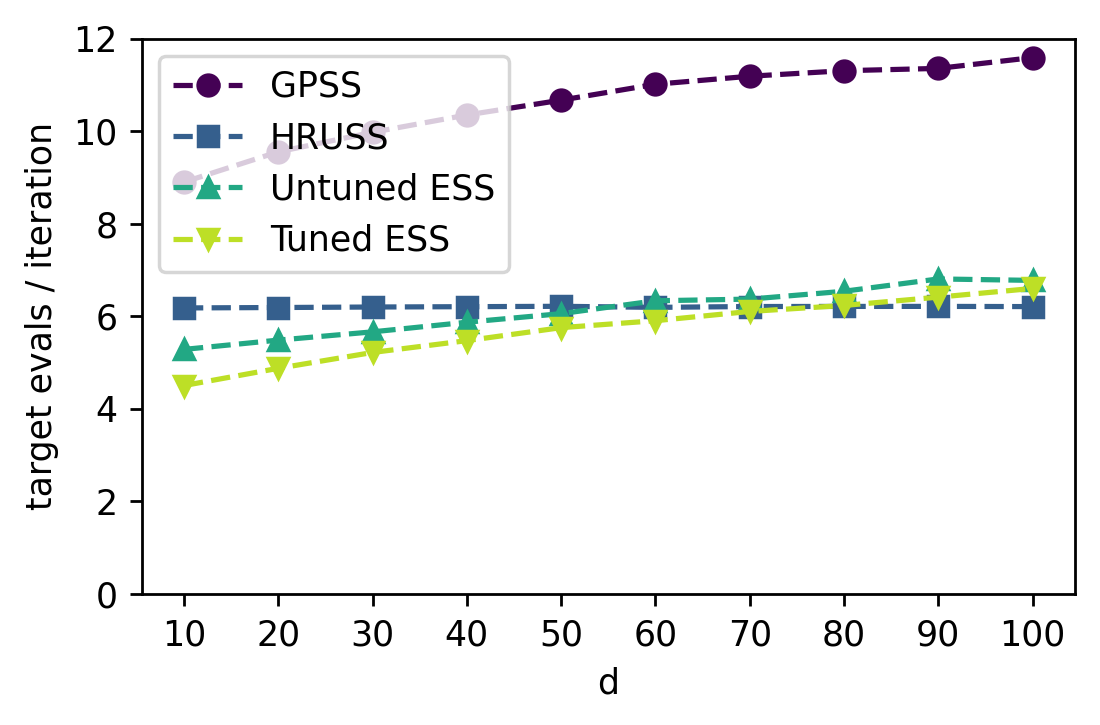

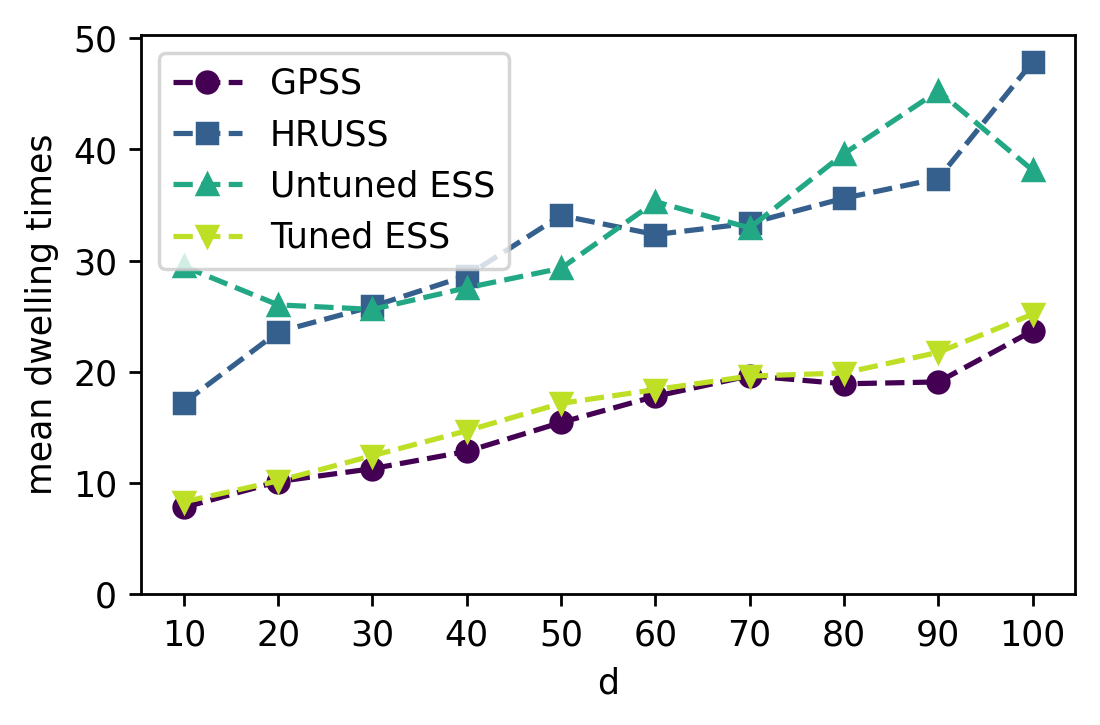

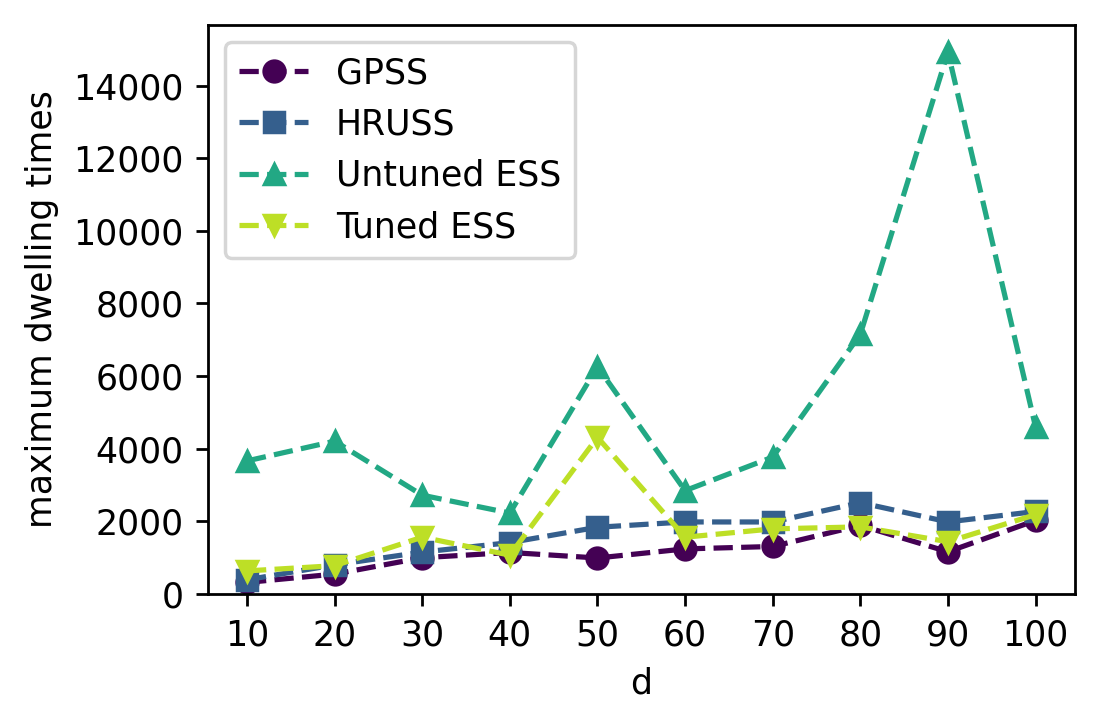

In [14]:
pfs.dim_dep_plot(ds, tdes_per_it, "target evals / iteration", names, dpi=dpi, 
                 filepath = path_prefix + "tdes_per_it.png", ylim=(0,12))
pfs.dim_dep_plot(ds, mean_dts, "mean dwelling times", names, dpi=dpi,
                 filepath = path_prefix + "mean_dts.png", ylim=(0,1.05 * np.max(mean_dts)))
pfs.dim_dep_plot(ds, max_dts, "maximum dwelling times", names, dpi=dpi,
                 filepath = path_prefix + "max_dts.png", ylim=(0,1.05 * np.max(max_dts)))

The above two plots show that the sample quality, in terms of mean and maximum dwelling time, of GPSS is at least on par with that of its competitors throughout all of the considered dimensions. Moreover, in the mean dwelling time category, only tuned ESS can keep up with GPSS. However, the plot above these two shows that the high quality samples of GPSS come at the cost of it requiring about twice as many target density evaluations per iteration as each competitor.

In [15]:
def plot_moxes(moxes, snames, figsize=(10,10), size=1, linewidth=None, filepath=None):
    maxl = 50
    nsam = len(snames)
    plt.figure(figsize=figsize, dpi=dpi, constrained_layout=True)
    for i in range(nsam):
        plt.subplot(nsam, 1, i+1)
        plt.title(snames[i])
        plt.scatter(range(moxes[i].shape[0]), moxes[i], s=size)
    if filepath != None:
        plt.savefig(filepath)
    plt.show()

d = 100:


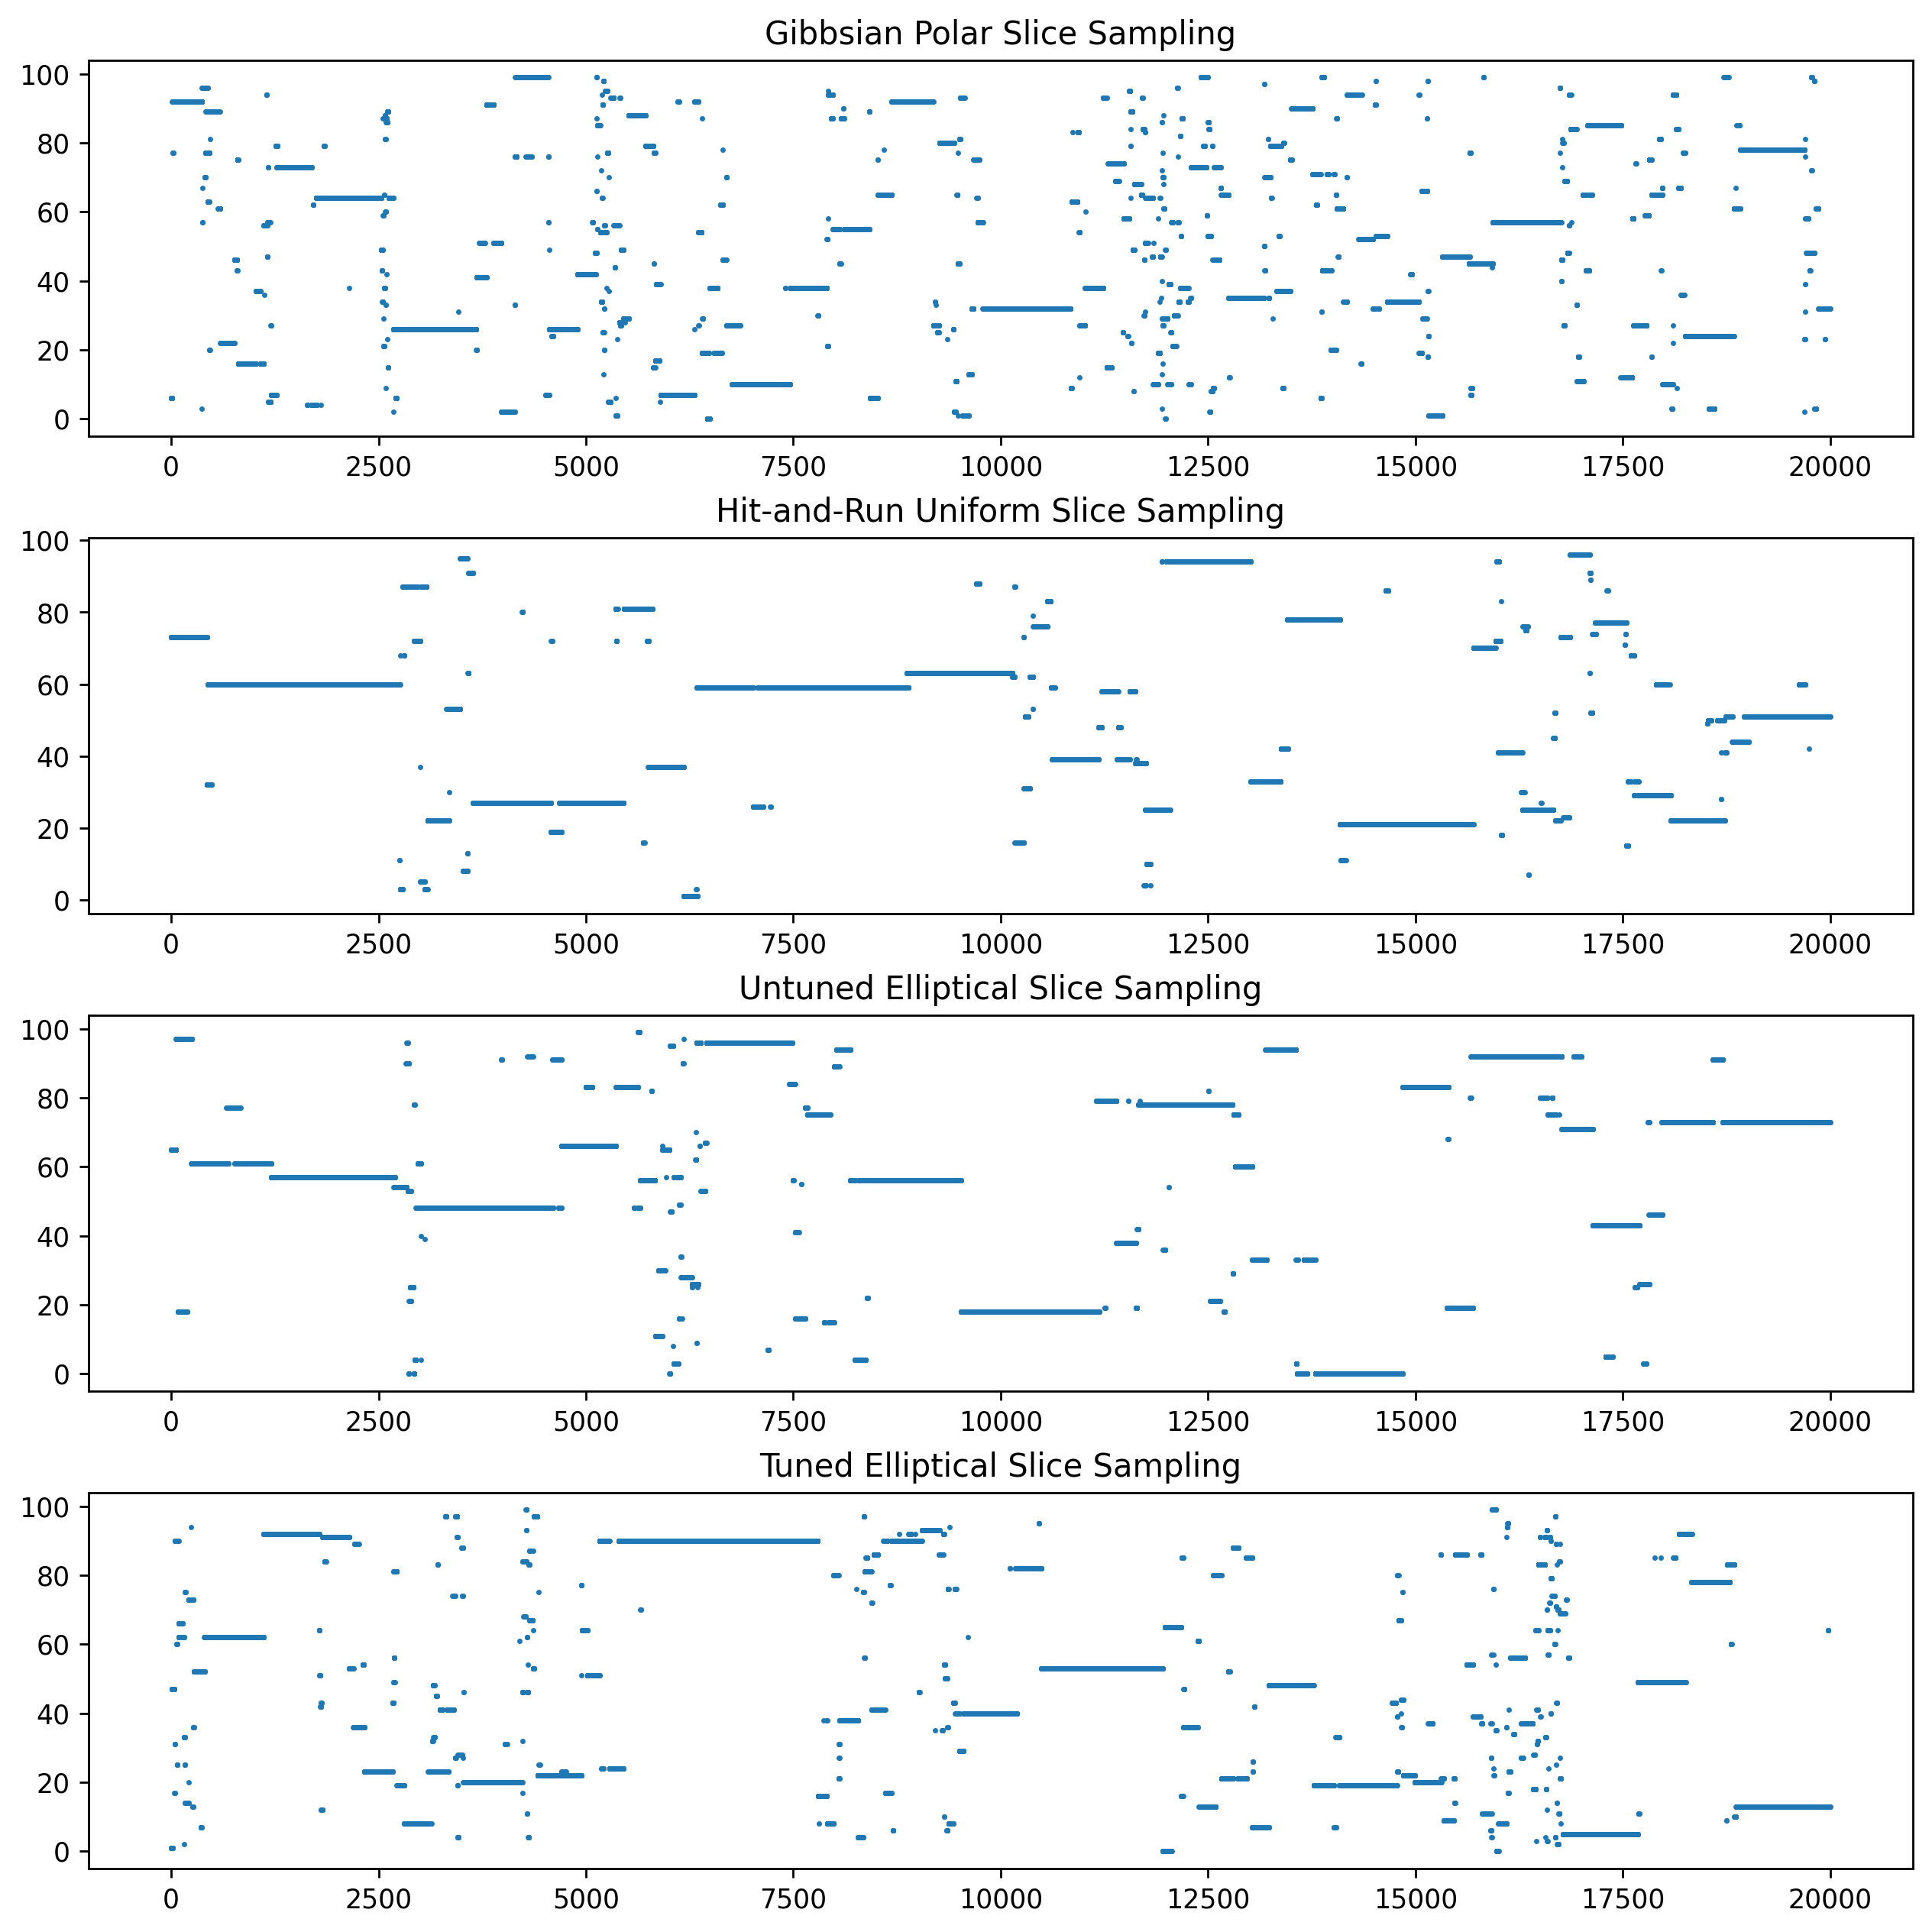

In [16]:
i_d = nd-1
window = int(2e4)
print("d = {}:".format(ds[i_d]))
pmoxes = [moxes[i_s][i_d][-window:] for i_s in range(nsam)]
plot_moxes(pmoxes, long_names, filepath = path_prefix + "moxes.png")

The above plot suggests that GPSS mode-jumps fairly consistently, rarely getting stuck for very long. HRUSS and untuned ESS are shown to get stuck in a mode pair for large numbers of iterations all the time. Tuned ESS appears to jump extremely frequently some of the time, but still occasionally gets stuck for many iterations.